In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS


### Import libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [4]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 9)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4


In [5]:
rainfall_departure_df = pd.read_csv('../../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(rainfall_departure_df.shape)
rainfall_departure_df.head()

(4004, 6)


,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON
0,BAGALKOTE,0.0,2008,1,-100.0,WINTER
1,BELLARY,0.0,2008,1,-100.0,WINTER
2,KOLAR,0.0,2008,1,-100.0,WINTER
3,GULBARGA,0.0,2008,1,-100.0,WINTER
4,BANGALORE URBAN,0.1,2008,1,-88.0,WINTER


### Dataset Transformation

In [6]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DAY'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE
0,2029.0,2011,1,1
1,3084.0,2011,1,2
2,2776.0,2011,1,3
3,2311.0,2011,1,4
4,1847.0,2011,1,5


In [7]:
rainfall_departure_df = rainfall_departure_df[rainfall_departure_df['DISTRICTS'] == 'KODAGU']
rainfall_departure_df['YEAR'] = rainfall_departure_df['YEAR'].astype(float)
rainfall_departure_df['MONTH'] = rainfall_departure_df['MONTH'].astype(float)
rainfall_departure_df.shape

(156, 6)

### Dataset and DataLoader

In [8]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(rainfall_departure_df['SEASON'].unique())

In [9]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 4), (330, 4))

In [10]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, year, month, date = self.df.iloc[index].values
        _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = prev_rainfall_departure_df['RAINFALL'].values.mean()
        prev_avg_departure = prev_rainfall_departure_df['DEPARTURE'].values.mean()
        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(date_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), (torch.FloatTensor([inflow]), torch.FloatTensor([monthly_rainfall]))
    
    def __len__(self):
        return self.df.shape[0]

In [11]:
train_ds = InflowDataset(train_inflow_df)
val_ds = InflowDataset(val_inflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Model

In [12]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, ndate, nseason, cardinality=3):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=32)
        self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=32)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=32)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.SELU(),
            nn.Linear(in_features=16, out_features=32),
            nn.SELU()
        )

        self.conv_1 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.res_layer_1 = nn.Sequential(
            nn.BatchNorm2d(num_features=12),
            nn.SELU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=12),
            nn.SELU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        )
        # self.res_layer_1 = nn.ModuleList([nn.Sequential(
        #     nn.BatchNorm2d(num_features=128*4),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1)
        #     nn.BatchNorm2d(num_features=128*4),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1)
        # ) for i in range(cardinality)])
        self.hidden_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.res_layer_2 = nn.Sequential(
            nn.BatchNorm2d(num_features=6),
            nn.SELU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=6),
            nn.SELU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        # self.res_layer_2 = nn.ModuleList([nn.Sequential(
        #     nn.BatchNorm2d(num_features=128*2),
        #     nn.ReLU(),
        #     nn.Linear(in_features=128*2, out_features=128*2),
        #     nn.BatchNorm1d(num_features=128*2),
        #     nn.ReLU(),
        #     nn.Linear(in_features=128*2, out_features=128*2),
        # ) for i in range(cardinality)])
        self.hidden_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=1, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.rainfall_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.ReLU()
        )
        
        self.inflow_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            # nn.Linear(in_features=32, out_features=8),
            # nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_date, x_season, x_prev_data):
        bs = x_month.shape[0]

        month_out = self.month_emb(x_month)
        date_out = self.date_emb(x_date)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        month_date = torch.bmm(month_out.view(bs, -1, 1), date_out.view(bs, 1, -1))
        month_season = torch.bmm(month_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
        month_prev_data = torch.bmm(month_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))
        date_season = torch.bmm(date_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
        date_prev_date = torch.bmm(date_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))
        season_prev_date = torch.bmm(season_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))

        x = torch.stack([month_date, month_season, month_prev_data, date_season, date_prev_date, season_prev_date], axis=1)
        conv_out = self.conv_1(x)
        res_out_1 = self.res_layer_1(conv_out) + conv_out
        hidden_out_1 = self.hidden_layer_1(res_out_1)
        res_out_2 = self.res_layer_2(hidden_out_1) + hidden_out_1
        hidden_out_2 = self.hidden_layer_2(res_out_2)
        hidden_out_2 = hidden_out_2.view(bs, -1)
        
        rainfall_out = self.rainfall_layer(hidden_out_2)
        inflow_out = self.inflow_layer(hidden_out_2)

        return rainfall_out, inflow_out#.view(bs)
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

### Training

In [13]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
    criterion = nn.MSELoss()

    mean_inflow = train_inflow_df['INFLOW_CUSECS'].mean()
    mean_rainfall = rainfall_departure_df['RAINFALL'].mean()
    inflow_loss_weight = int((mean_inflow + mean_rainfall) / mean_inflow)
    rainfall_loss_weight = int((mean_inflow + mean_rainfall) / mean_rainfall)
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_date = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            y_inflow = yb[0].cuda()
            y_rainfall = yb[1].cuda()

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]
            loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)
            # loss = criterion(y_hat, y_inflow)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_date = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                y_inflow = yb[0].cuda()
                y_rainfall = yb[1].cuda()

                y_hat = model(x_month, x_date, x_season, x_prev_data)
                y_hat_rainfall = y_hat[0]
                y_hat_inflow = y_hat[1]
                loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-06:
            break
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [14]:
model = SimpleMLP(len(month_le.classes_), len(date_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [15]:
train(model, epochs=5, lr=1e-02)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch - 1 | LR - 0.01 | Train Loss - 38456500.16 | Val Loss - 19509076.81
Epoch - 2 | LR - 0.01 | Train Loss - 33296200.48 | Val Loss - 21871878.04
Epoch - 3 | LR - 0.01 | Train Loss - 31001520.2 | Val Loss - 17455566.2
Epoch - 4 | LR - 0.01 | Train Loss - 31948767.16 | Val Loss - 15452340.17
Epoch - 5 | LR - 0.01 | Train Loss - 30251515.7 | Val Loss - 15611353.98


In [16]:
train(model, epochs=100, lr=1e-03)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch - 1 | LR - 0.001 | Train Loss - 28610293.92 | Val Loss - 14708377.83
Epoch - 2 | LR - 0.001 | Train Loss - 28083811.93 | Val Loss - 15056116.17
Epoch - 3 | LR - 0.001 | Train Loss - 27395115.66 | Val Loss - 15067521.57
Epoch - 4 | LR - 0.001 | Train Loss - 27014396.62 | Val Loss - 14502078.88
Epoch - 5 | LR - 0.001 | Train Loss - 26777606.38 | Val Loss - 14883961.3
Epoch - 6 | LR - 0.001 | Train Loss - 26391456.9 | Val Loss - 14391862.23
Epoch - 7 | LR - 0.001 | Train Loss - 25936013.89 | Val Loss - 14571482.7
Epoch - 8 | LR - 0.001 | Train Loss - 25478967.68 | Val Loss - 15734847.7
Epoch - 9 | LR - 0.001 | Train Loss - 25468173.65 | Val Loss - 15477011.23
Epoch - 10 | LR - 0.001 | Train Loss - 24955285.38 | Val Loss - 15233903.53
Epoch - 11 | LR - 0.001 | Train Loss - 24784925.46 | Val Loss - 15009618.92
Epoch - 12 | LR - 0.001 | Train Loss - 24194213.67 | Val Loss - 15030933.92
Epoch - 13 | LR - 0.001 | Train Loss - 23988374.24 | Val Loss - 15646923.86
Epoch - 14 | LR - 0.001 |

In [17]:
model

SimpleMLP(
  (month_emb): Embedding(12, 32)
  (date_emb): Embedding(31, 32)
  (season_emb): Embedding(3, 32)
  (prev_data_layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): SELU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): SELU()
  )
  (conv_1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_layer_1): Sequential(
    (0): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): SELU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SELU()
    (5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (hidden_layer_1): Sequential(
    (0): Conv2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (res_layer_2): Sequential(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affin

### Prediction on Validation Dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


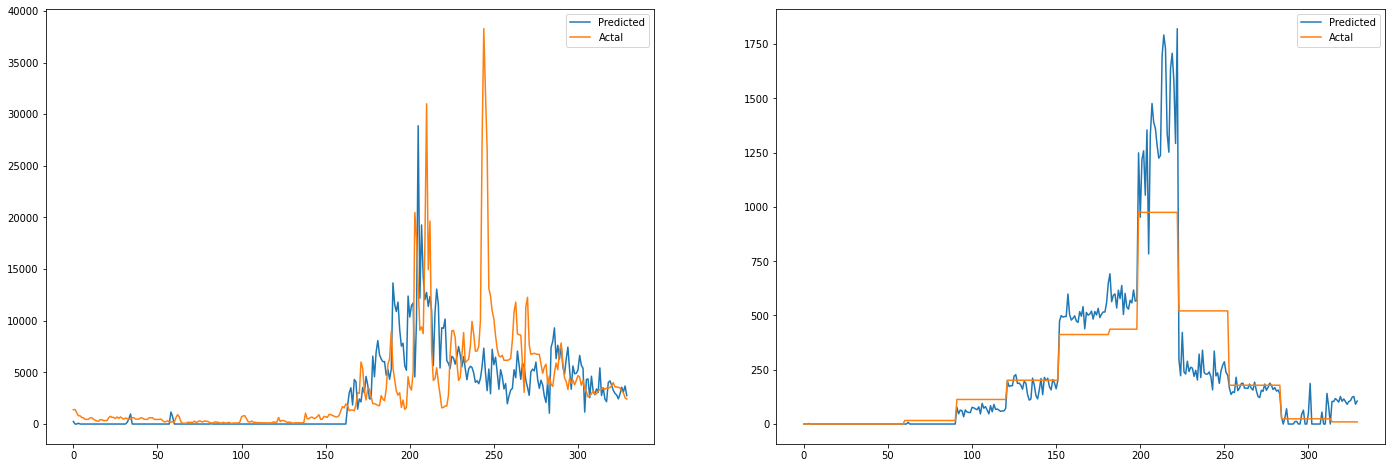

In [18]:
y_actual_rainfall, y_pred_rainfall = [], []
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_date = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()
        y_inflow = yb[0]
        y_rainfall = yb[1]

        y_hat = model(x_month, x_date, x_season, x_prev_data)
        y_hat_rainfall = y_hat[0]
        y_hat_inflow = y_hat[1]

        y_actual_rainfall += y_rainfall.data.tolist()
        y_actual_inflow += y_inflow.data.tolist()
        y_pred_rainfall += y_hat_rainfall.cpu().data.tolist()
        y_pred_inflow += y_hat_inflow.cpu().data.tolist()

y_actual_rainfall = np.array(y_actual_rainfall).flatten()
y_actual_inflow = np.array(y_actual_inflow).flatten()
y_pred_rainfall = np.array(y_pred_rainfall).flatten()
y_pred_inflow = np.array(y_pred_inflow).flatten()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))
ax1.plot(y_pred_inflow, label='Predicted')
ax1.plot(y_actual_inflow, label='Actal')
ax1.legend()
ax2.plot(y_pred_rainfall, label='Predicted')
ax2.plot(y_actual_rainfall, label='Actal')
ax2.legend()
plt.show()

### Prediction on entire Dataset

In [19]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_date = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()
            y_inflow = yb[0]
            y_rainfall = yb[1]

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]

    return y_hat_inflow.data.cpu().view(-1).tolist(), y_hat_rainfall.data.cpu().view(-1).tolist()
    # return y_hat.data.cpu().view(-1).tolist()

In [20]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DATE']).copy()
model_test_df['Predicted_Inflow'], model_test_df['Predicted_Rainfall'] = pred(model_test_df)
# model_test_df['Predicted_Inflow'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,MONTH,DATE,Predicted_Inflow,Predicted_Rainfall
0,2029.0,2011,1,1,1539.711548,5.927420
31,1987.0,2011,2,1,1258.356812,3.869440
59,635.0,2011,3,1,0.000000,0.000000
90,587.0,2011,4,1,0.000000,153.372955
120,1719.0,2011,5,1,0.000000,167.433273
151,1306.0,2011,6,1,1499.786255,703.803894
181,7601.0,2011,7,1,7136.678223,490.238678
212,8588.0,2011,8,1,8672.421875,450.136444
243,18132.0,2011,9,1,19832.230469,270.024200
273,2668.0,2011,10,1,3143.177979,148.353348


In [22]:
avg_daily_pred_inflow = model_test_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values
avg_daily_pred_rainfall = model_test_df.groupby(['MONTH'])['Predicted_Rainfall'].mean().values
avg_daily_actual_rainfall = rainfall_departure_df.groupby(['MONTH'])['RAINFALL'].mean().values

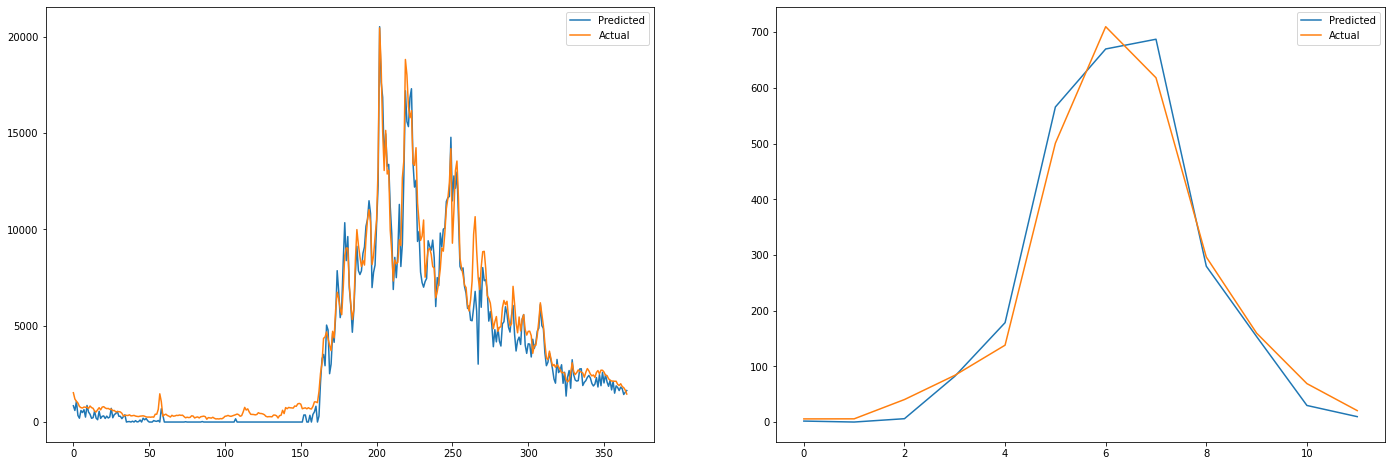

In [23]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax1.plot(avg_daily_pred_inflow, label='Predicted')
ax1.plot(avg_daily_actual_inflow, label='Actual')
ax1.legend()
ax2.plot(avg_daily_pred_rainfall, label='Predicted')
ax2.plot(avg_daily_actual_rainfall, label='Actual')
ax2.legend()
plt.show()

In [24]:
model_test_df['Predicted_Rainfall'].describe()

count    3274.000000
mean      229.668816
std       290.254052
min         0.000000
25%         0.000000
50%       117.238297
75%       435.474457
max      2091.491211
Name: Predicted_Rainfall, dtype: float64

In [25]:
rainfall_departure_df['RAINFALL'].describe()

count     156.000000
mean      220.685897
std       287.744814
min         0.000000
25%        13.800000
50%       103.800000
75%       314.500000
max      1318.100000
Name: RAINFALL, dtype: float64

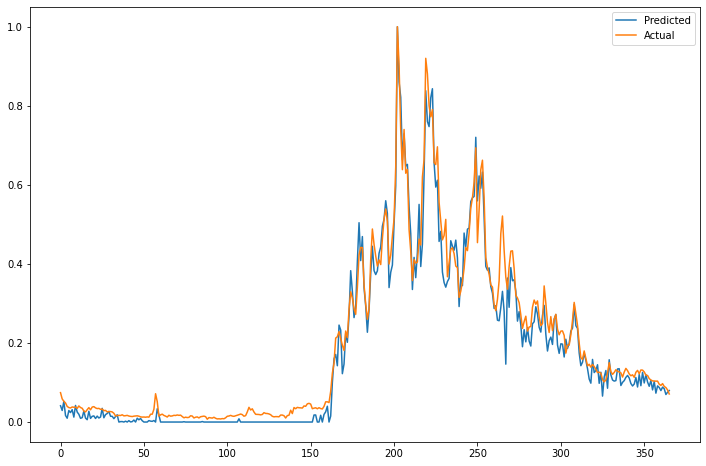

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')

plt.legend()
plt.show()

In [27]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

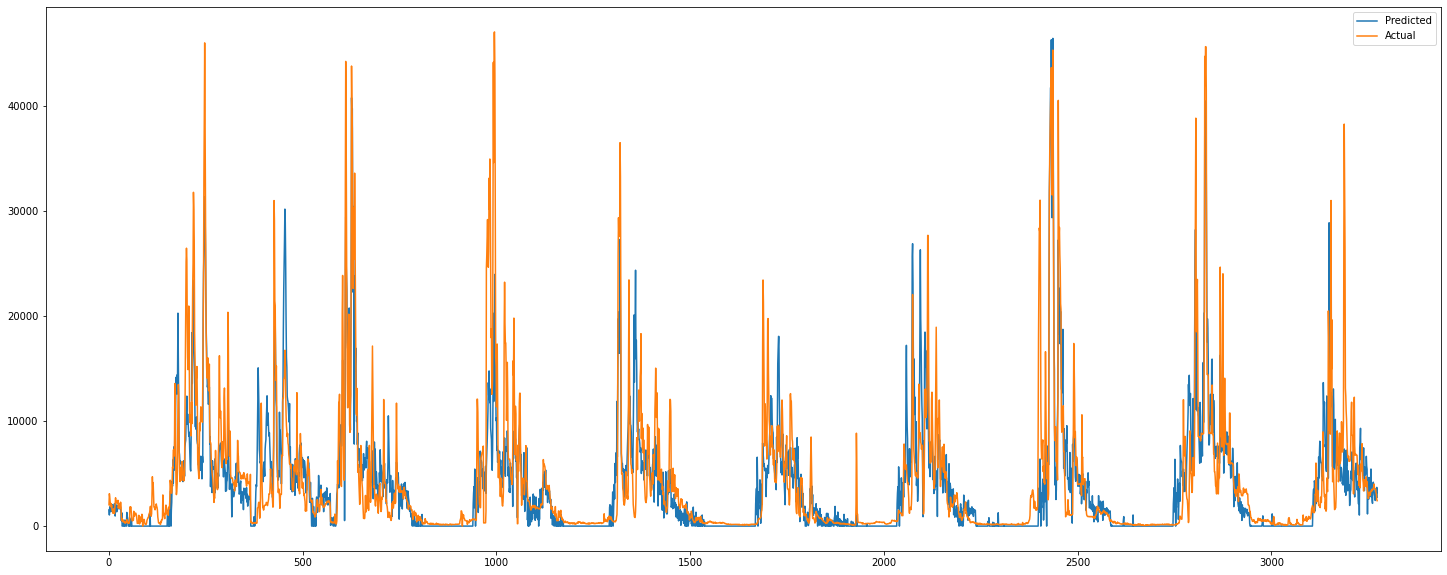

In [28]:
plt.figure(figsize=(25, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [29]:
pred_rainfall_df = model_test_df[['YEAR', 'MONTH', 'Predicted_Rainfall']].groupby(['YEAR', 'MONTH']).mean().reset_index()
rainfall_with_pred_df = rainfall_departure_df.merge(pred_rainfall_df, on=['YEAR', 'MONTH'])
rainfall_with_pred_df = rainfall_with_pred_df.sort_values(by=['YEAR', 'MONTH']).reset_index()
rainfall_with_pred_df

,index,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON,Predicted_Rainfall
0,0,KODAGU,0.7,2011.0,1.0,-80.0,WINTER,2.807628
1,10,KODAGU,22.2,2011.0,2.0,429.0,WINTER,1.279828
2,19,KODAGU,13.2,2011.0,3.0,-29.0,SUMMER,0.373678
3,27,KODAGU,138.5,2011.0,4.0,54.0,SUMMER,131.926834
4,35,KODAGU,107.5,2011.0,5.0,-30.0,SUMMER,167.309453
...,...,...,...,...,...,...,...,...
109,73,KODAGU,974.9,2020.0,8.0,66.0,MONSOON,1376.060671
110,83,KODAGU,521.1,2020.0,9.0,126.0,MONSOON,252.172909
111,93,KODAGU,178.7,2020.0,10.0,-14.0,WINTER,163.004021
112,103,KODAGU,24.1,2020.0,11.0,-69.0,WINTER,25.952489


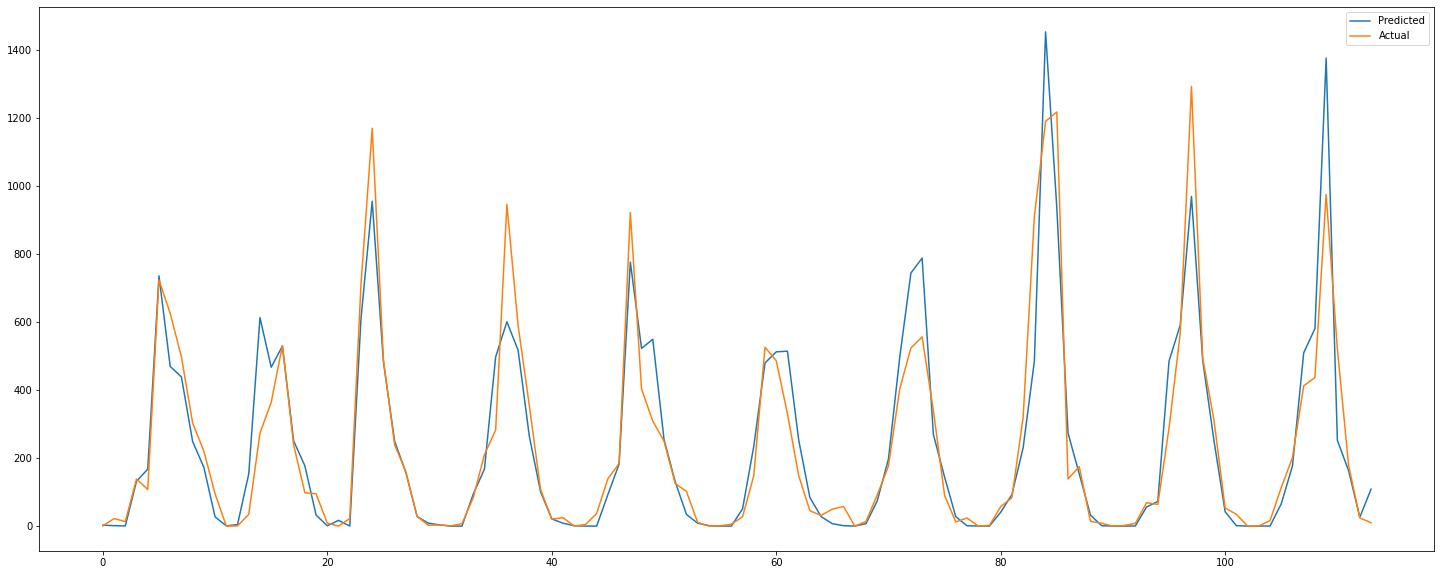

In [30]:
plt.figure(figsize=(25, 10))
plt.plot(rainfall_with_pred_df['Predicted_Rainfall'], label='Predicted')
plt.plot(rainfall_with_pred_df['RAINFALL'], label='Actual')
plt.legend()
plt.show()

In [31]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 6), (330, 6))

In [32]:
train_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] < 2020]
val_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] == 2020]
train_rainfall_with_pred.shape, val_rainfall_with_pred.shape

((102, 8), (12, 8))

In [33]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5# + ((train_rainfall_with_pred['RAINFALL'] - train_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

3719.731437379941

In [34]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5# + ((val_rainfall_with_pred['RAINFALL'] - val_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

4265.314687988876

In [ ]:
# torch.save(model.state_dict(), 'inflow_rainfall_multihead_model.pth')